In [67]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from utils import eda, feat_eng, data_prep

In [68]:
warnings.simplefilter(action="ignore")
pd.set_option("display.width",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.rcParams["figure.figsize"] = (12,5)

In [69]:
df = eda.load_data("./data.csv")

# EDA

## Big Picture

In [70]:
df.head()

,type,boat_class,year,condition,length_ft,beam_ft,hull_material,fuel_type,num_engines,total_hp,price
1,power,power-center,1992,used,21.000,8.500,fiberglass,gasoline,1,150.000,16500.000
3,power,power-sportcruiser,2018,used,40.000,11.000,fiberglass,diesel,2,800.000,539000.000
5,power,power-deck,2020,new,18.000,7.420,fiberglass,gasoline,1,75.000,26995.000
6,power,power-expresscruiser,2015,used,32.000,10.330,fiberglass,gasoline,2,600.000,169995.000
8,power,power-aft,1994,used,44.000,15.000,fiberglass,diesel,2,700.000,109900.000


In [71]:
df.shape

(18903, 11)

In [72]:
df.columns

Index(['type', 'boat_class', 'year', 'condition', 'length_ft', 'beam_ft', 'hull_material', 'fuel_type', 'num_engines', 'total_hp', 'price'], dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18903 entries, 1 to 20000
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           18903 non-null  object 
 1   boat_class     18903 non-null  object 
 2   year           18903 non-null  int64  
 3   condition      18903 non-null  object 
 4   length_ft      18903 non-null  float64
 5   beam_ft        12399 non-null  float64
 6   hull_material  18903 non-null  object 
 7   fuel_type      15951 non-null  object 
 8   num_engines    18903 non-null  int64  
 9   total_hp       18055 non-null  float64
 10  price          18903 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.7+ MB


In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,18903.000,2013.146,10.503,1910.000,2011.000,2019.000,2019.000,2020.000
length_ft,18903.000,23.804,14.613,1.000,18.000,21.000,25.000,375.000
beam_ft,12399.000,16.197,36.834,0.080,7.830,8.500,9.000,1311.000
num_engines,18903.000,1.070,0.426,0.000,1.000,1.000,1.000,4.000
total_hp,18055.000,112.849,286.138,0.000,0.000,0.000,115.000,7200.000
price,18903.000,647146.881,73095667.967,500.000,19255.000,34195.000,57830.000,9999999999.000


In [75]:
num_cols, cat_cols = eda.grab_cols(df,True)

************************* SUMMARY **************************
# of categoric variables: 5
['type', 'boat_class', 'condition', 'hull_material', 'fuel_type']
# of numeric variables: 6
['year', 'length_ft', 'beam_ft', 'num_engines', 'total_hp', 'price']


## Categoric Variables

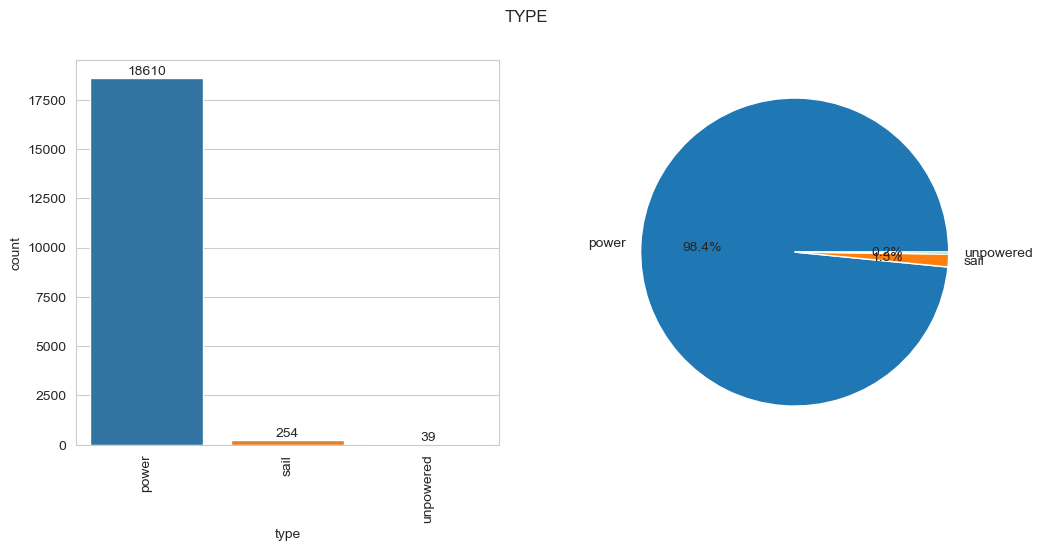

type
power       655864.624
sail        107258.261
unpowered     3416.254
Name: price, dtype: float64


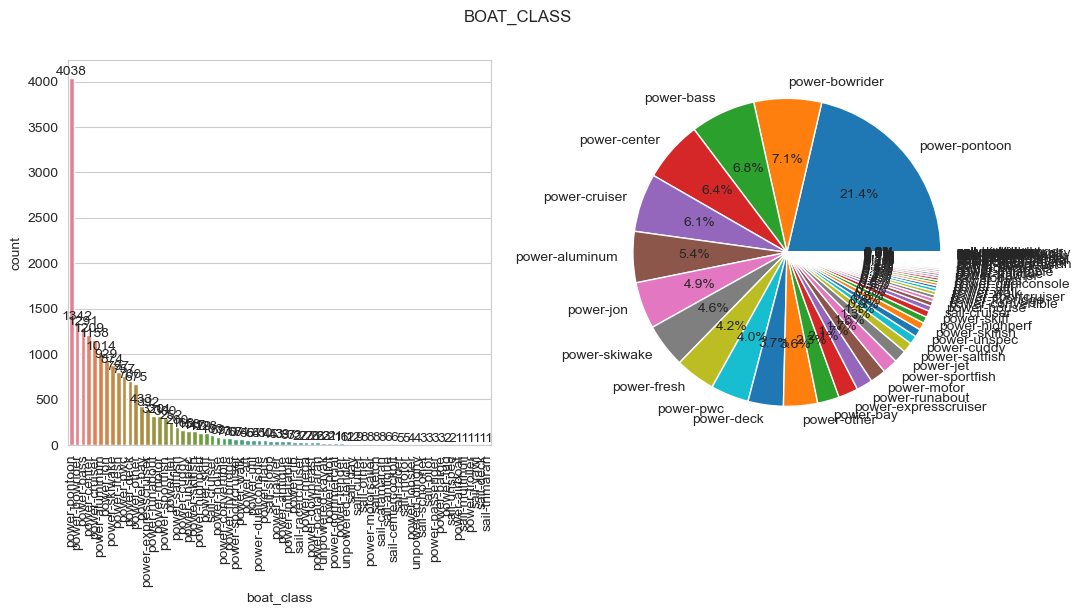

boat_class
power-aft            74831.286
power-airboat       139889.000
power-aluminum       26790.278
power-antique        92108.256
power-barge        3691633.333
                       ...    
sail-unspec          37249.500
sail-yawl            99500.000
unpowered-dinghy      3520.000
unpowered-kayak       1956.474
unpowered-tender      6179.583
Name: price, Length: 72, dtype: float64


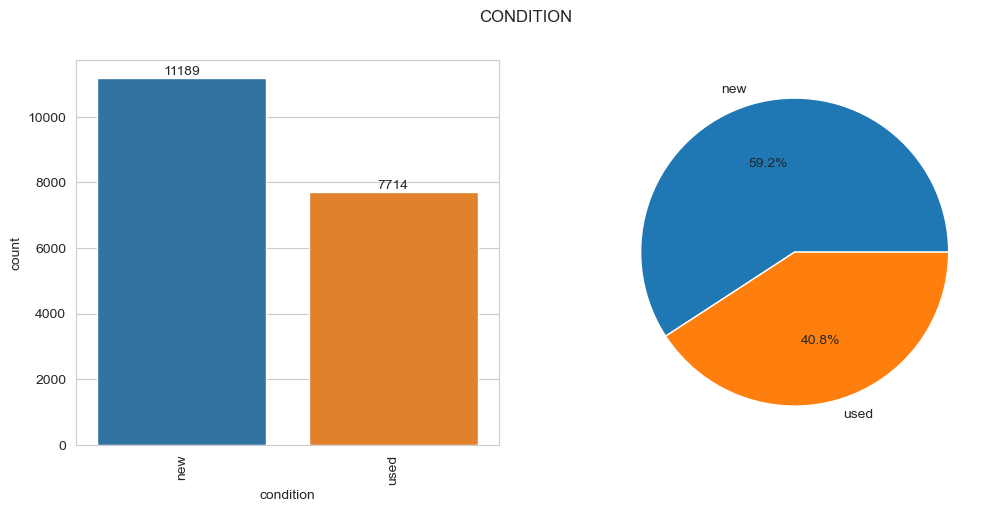

condition
new    1033893.184
used     86179.240
Name: price, dtype: float64


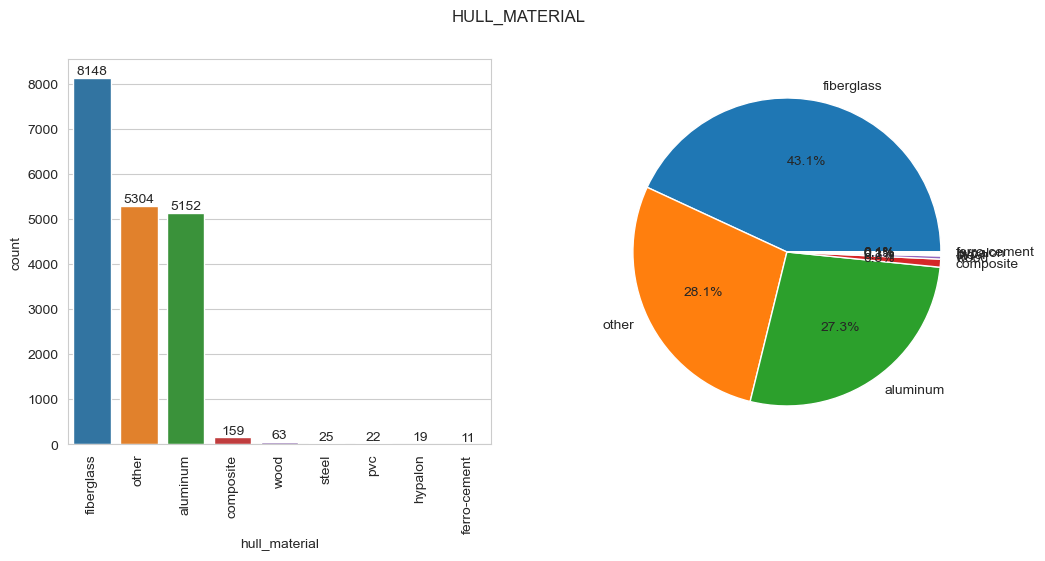

hull_material
aluminum          33703.115
composite      69445103.581
ferro-cement      27334.091
fiberglass        95316.701
hypalon           31693.842
other             39516.191
pvc                6587.182
steel            914488.920
wood             118463.746
Name: price, dtype: float64


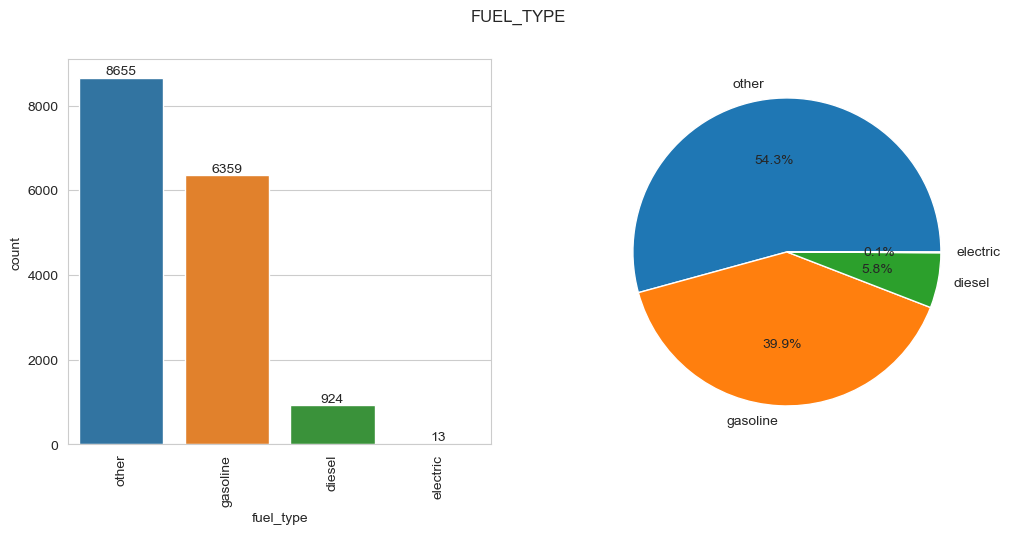

fuel_type
diesel      391092.310
electric     72989.769
gasoline   1788027.215
other        48255.354
Name: price, dtype: float64


In [76]:
for col in cat_cols:
    eda.cat_summary(df,col)

## Numeric Variables

In [77]:
## EXPLANATION

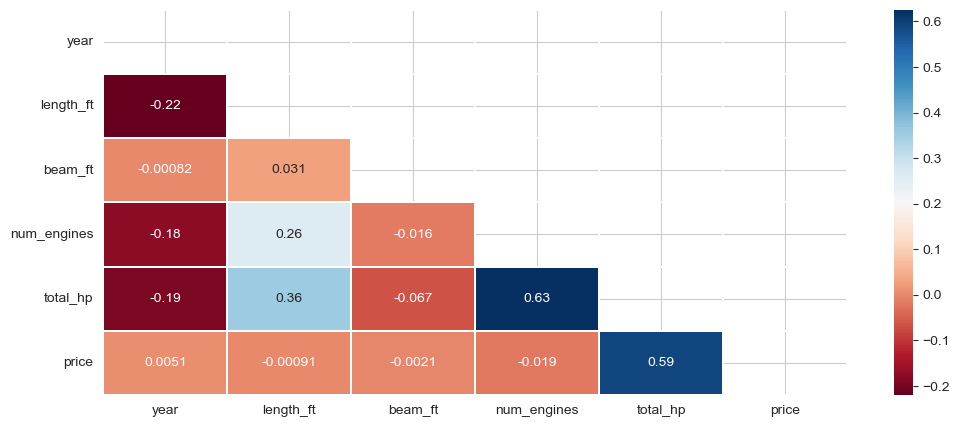

In [78]:
eda.corr_analysis(df,num_cols)

# Data Preprocessing

## Duplicates

In [79]:
df[df.duplicated(keep=False)].sort_values(by="price")

,type,boat_class,year,condition,length_ft,beam_ft,hull_material,fuel_type,num_engines,total_hp,price
12957,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10581,power,power-jon,2016,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10578,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10574,power,power-jon,2016,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
10085,power,power-jon,2017,new,10.000,3.830,aluminum,NaN,1,0.000,519.000
...,...,...,...,...,...,...,...,...,...,...,...
62,power,power-mega,2019,new,48.000,NaN,fiberglass,diesel,2,870.000,799000.000
50,power,power-mega,2019,new,50.000,NaN,fiberglass,diesel,2,1340.000,1099000.000
49,power,power-mega,2019,new,50.000,NaN,fiberglass,diesel,2,1340.000,1099000.000
54,power,power-mega,2019,new,51.000,NaN,fiberglass,diesel,2,1340.000,1225000.000


In [80]:
df.drop_duplicates(inplace=True)

In [81]:
df.duplicated().sum()

0

## Nulls

<Axes: >

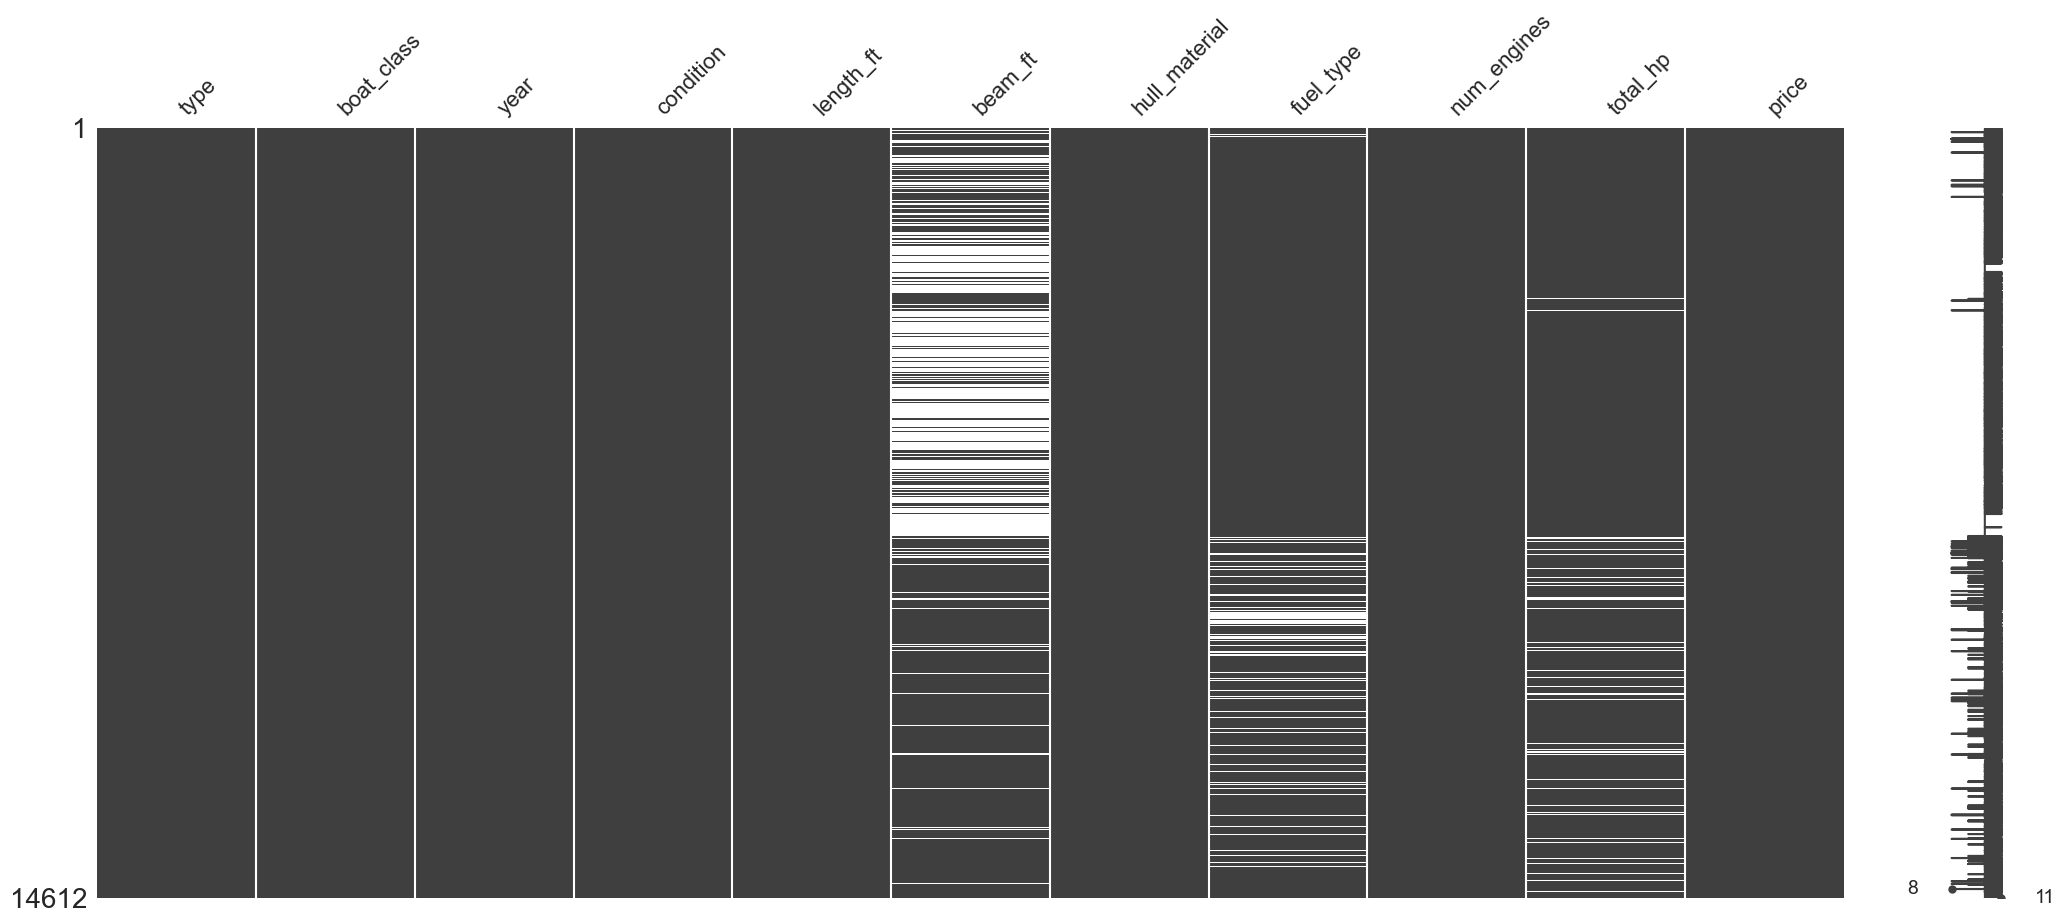

In [82]:
msno.matrix(df)

In [83]:
df["total_hp"].fillna(0,inplace=True)

In [84]:
data_prep.fill_nulls(df)

In [85]:
df.isna().sum().any()

False

## Outliers

In [86]:
for col in num_cols:
    if data_prep.check_outliers(df,col):
        print(f"{col.upper()}")
        print(f"# of outliers: {len(data_prep.get_outliers(df,col))}\n")
        data_prep.replace_outliers(df,col)

YEAR
# of outliers: 9

LENGTH_FT
# of outliers: 85

BEAM_FT
# of outliers: 6

TOTAL_HP
# of outliers: 101

PRICE
# of outliers: 257


# Feature Extraction

In [87]:
df = feat_eng.feat_extract(df)

In [88]:
num_cols, cat_cols = eda.grab_cols(df,True)

************************* SUMMARY **************************
# of categoric variables: 5
['type', 'condition', 'hull_material', 'fuel_type', 'class']
# of numeric variables: 9
['length_ft', 'beam_ft', 'num_engines', 'total_hp', 'price', 'lenght_beam', 'hp_per_lb', 'hp_per_engine', 'boat_age']


## Encoding

In [89]:
feat_eng.rare_encoding(df,"hull_material",0.2,"other")
feat_eng.rare_encoding(df,"class",0.04,"other")
feat_eng.rare_encoding(df,"type",0.5,"unpowered")

In [90]:
df = pd.get_dummies(df,columns=cat_cols,drop_first=True,dtype="int")

In [91]:
df

,length_ft,beam_ft,num_engines,total_hp,price,lenght_beam,hp_per_lb,hp_per_engine,boat_age,type_unpowered,condition_used,hull_material_fiberglass,hull_material_other,fuel_type_electric,fuel_type_gasoline,fuel_type_other,class_bass,class_bowrider,class_center,class_cruiser,class_other,class_pontoon,class_skiwake
1,21.000,8.500,1,150.000,16500.000,178.500,0.840,150.000,33,0,1,1,0,0,1,0,0,0,1,0,0,0,0
3,40.000,11.000,2,800.000,491749.000,440.000,1.818,400.000,7,0,1,1,0,0,0,0,0,0,0,0,1,0,0
5,18.000,7.420,1,75.000,26995.000,133.560,0.562,75.000,5,0,0,1,0,0,1,0,0,0,0,0,1,0,0
6,32.000,10.330,2,600.000,169995.000,330.560,1.815,300.000,10,0,1,1,0,0,1,0,0,0,0,0,1,0,0
8,44.000,15.000,2,700.000,109900.000,660.000,1.061,350.000,31,0,1,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,25.000,8.500,0,0.000,31973.000,212.500,0.000,0.000,12,0,1,0,0,0,1,0,0,0,0,0,0,1,0
19997,19.330,8.000,1,0.000,26995.000,154.640,0.000,0.000,12,0,1,1,0,0,1,0,0,0,0,0,1,0,0
19998,22.000,7.670,0,0.000,39995.000,168.740,0.000,0.000,6,0,0,1,0,0,1,0,0,0,0,0,1,0,0
19999,25.000,8.500,0,0.000,16900.000,212.500,0.000,0.000,21,0,1,0,0,0,1,0,0,0,0,0,0,1,0


## Feature Selection

In [92]:
X = df.drop("price",axis=1)
Y = df["price"]

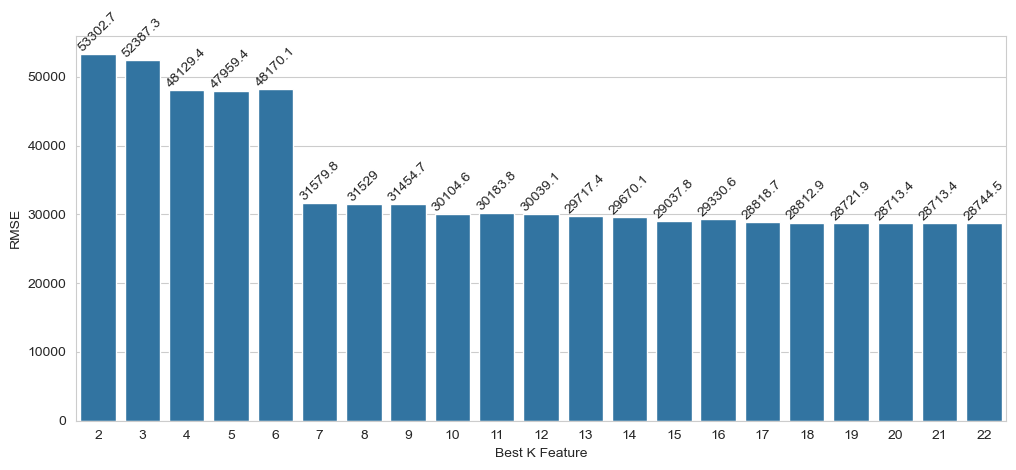

In [93]:
feat_eng.feat_select(X,Y,2,X.shape[1])

In [94]:
# I prefer 10 features
feat_selector = SelectKBest(mutual_info_regression,k=10)
feat_selector.fit(X,Y)

SelectKBest(score_func=<function mutual_info_regression at 0x0000020209F52A70>)

In [95]:
selected_feats = X.columns[feat_selector.get_support()]
selected_feats

Index(['length_ft', 'beam_ft', 'num_engines', 'total_hp', 'lenght_beam', 'hp_per_lb', 'hp_per_engine', 'boat_age', 'condition_used', 'hull_material_fiberglass'], dtype='object')

In [96]:
X = X.loc[:,selected_feats]

## Model

In [97]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [98]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.15)

In [99]:
print(f"# of train samples {x_train.shape[0]}")
print(f"# of validation samples {x_val.shape[0]}")
print(f"# of test samples {x_test.shape[0]}")

# of train samples 9935
# of validation samples 1754
# of test samples 2923


In [100]:
model = LGBMRegressor(verbosity=-1,n_jobs=-1)
params = {"max_depth":[12,13,14],
          "learning_rate":[0.085,0.1,0.15],
          "n_estimators":[200,250,300]}

In [101]:
rcv = GridSearchCV(model,params,scoring="neg_root_mean_squared_error",verbose=0).fit(x_val,y_val)

In [102]:
rcv.best_params_

{'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 200}

In [103]:
-rcv.best_score_

37148.06336701937

In [104]:
model.set_params(**rcv.best_params_)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
rmse

28829.113691738195

In [105]:
pickle.dump(model,open("model.pkl","wb"))